In [1]:
import simplify as sp #Our package
import numpy as np

### Define function f_v anf tilde_f_v.  
tilde_f_v has to satisfy  
tilde_f_v(pauli_word, c) = $[\frac{\partial}{\partial c}$ f_v(pauli_word, c)$]\cdot$ c  
They determines the cost function that will be used in the simplification.  
pauli_word is something like (0,2,3,0,1,2,0,0) (tuple)  
c is a float

In [2]:
# Here, f_v(pauli_word, c) is taken close to 
# (weight of pauli_word)・sgn(c)
# and differentiable by c by using tanh function
def f_v(pauli_word, c):
    pauli_arr = np.array(pauli_word)
    weight = (pauli_arr != 0).sum()
    return weight * np.tanh(1000.0*c)

def tilde_f_v(pauli_word, c):
    pauli_arr = np.array(pauli_word)
    weight = (pauli_arr != 0).sum()
    return weight * 1000 * c / (np.cosh(1000.0*c) ** 2)

# test
pauli_word1 = (0, 2, 3, 0, 1, 2, 0, 0)
pauli_word2 = (1, 2, 2, 3, 3, 3, 4, 4, 4, 4)
print(f_v(pauli_word1, 1.0)) #4.0
print(f_v(pauli_word1, -1.0)) #-4.0
print(f_v(pauli_word2, 2.0)) #10.0

4.0
-4.0
10.0


### Simplification of a Hamiltonian generated by randomly applying pauli rotations to a simple Hamiltonian  

In our program, Hamiltonian $H$ is represented by the coefficients of $H$ when expanded with the pauli product basis.  
For example, a $2^3\times 2^3$ Hamiltonian is represented by a "vec" (numpy.ndarray) with shape=(4,4,4) where  
vec[j1,j2,j3] = (coefficient for $\sigma_{j1}\otimes \sigma_{j2}\otimes \sigma_{j3}$)  
Below, we first prepare vec corresponding to $X\otimes I\otimes I$ and apply random rotation $e^{-i\sigma_{j1}\otimes \sigma_{j2}\otimes \sigma_{j3}\theta}$,  
where $(j1,j2,j3)\in \{0,1,2,3\}^3$ and $\theta\in [-\pi /2, \pi /2]$ is randomly chosen, to vec for "N_complicate" times.  
This process can be done using "sp.pauli_word_to_vec" and "sp.complicate_from_vec"

In [ ]:
n = 3 #3 qubit
N_complicate = 3 #number of applying random rotation to vec_base
pauli_word_base = (1, 0, 0) #XII
vec_base = sp.pauli_word_to_vec(pauli_word_base)
print(vec_base) #[[[0. 0. 0. 0.]
                # [0. 0. 0. 0.]
                # [0. 0. 0. 0.]
                # [0. 0. 0. 0.]]

                # [[1. 0. 0. 0.]
                # [0. 0. 0. 0.]
                # [0. 0. 0. 0.]
                # [0. 0. 0. 0.]]

                # [[0. 0. 0. 0.]
                # [0. 0. 0. 0.]
                # [0. 0. 0. 0.]
                # [0. 0. 0. 0.]]

                # [[0. 0. 0. 0.]
                # [0. 0. 0. 0.]
                # [0. 0. 0. 0.]
                # [0. 0. 0. 0.]]]
vec_ini, _, _ = sp.complicate_from_vec(vec_base, N_complicate, n, seed=1234)
print(vec_ini) #[[[ 0.00000000e+00  4.16333634e-17  6.93889390e-18 -2.55271050e-01]
                # [-2.42861287e-17  4.12865375e-01  0.00000000e+00  3.46944695e-18]
                # [ 1.04083409e-17  8.40370904e-02  0.00000000e+00  3.46944695e-18]
                # [ 0.00000000e+00  1.14025558e-01  6.93889390e-18  2.77555756e-17]]

                # [[ 1.17393903e-01  0.00000000e+00  1.09305224e-01  2.05170038e-01]
                # [-1.04083409e-17  0.00000000e+00  0.00000000e+00 -1.73472348e-17]
                # [-6.93889390e-18  3.07802836e-01  1.38777878e-17  3.29597460e-17]
                # [ 0.00000000e+00  2.32466446e-01  0.00000000e+00 -5.55111512e-17]]

                # [[ 2.77555756e-17  2.78237939e-01  0.00000000e+00 -8.32667268e-17]
                # [-2.73635749e-02  3.46944695e-18 -2.94789542e-01  0.00000000e+00]
                # [-8.79986831e-04  0.00000000e+00 -6.12593230e-02  7.63278329e-17]
                # [-9.80820359e-02  5.55111512e-17  1.30826882e-01  2.45567003e-01]]

                # [[ 7.38657728e-02  0.00000000e+00 -1.09934585e-01  0.00000000e+00]
                # [-1.04083409e-17 -1.00583578e-01  0.00000000e+00  3.46944695e-18]
                # [-1.04083409e-17  4.94156525e-01  0.00000000e+00  1.04083409e-17]
                # [-6.93889390e-18  0.00000000e+00 -1.38777878e-17  0.00000000e+00]]]

Then, we simplify vec_ini using "sp.simplifier" instance.  
The following parameters can be specified in the simplification:  
- thres (default=0.01), n_wait (default=10): Determines when the simplification process stops. The neccessary and sufficient condition for the simplification process to stop is that rotation angles (a measure on the magnitude of updates) are smaller than thres for more than n_wait times.  
- verbose (default=True): Whether or not to show a cost in each process  
- random (default=True): Whether or not to change the basis to find  
$\underset{\vec{v}}{\mathrm{max}} |e_{\vec{v}}|$, where  
$-i[F(H)+\tilde{F}(H), H]=\sum_{\vec{v}}e_{\vec{v}}\sigma_{\vec{v}}$.
Namely, if random == True, we randomly change the basis $\sigma_{\vec{v}}$ to  
$[e^{-i(\vec{u}_1\cdot\vec{\sigma}\theta_1)}\otimes e^{-i(\vec{u}_n\cdot\vec{\sigma}\theta_n)}]\sigma_{\vec{v}}[e^{i(\vec{u}_1\cdot\vec{\sigma}\theta_1)}\otimes e^{i(\vec{u}_n\cdot\vec{\sigma}\theta_n)}]$  
($\vec{u}_1,\ldots ,\vec{u}_n$ on surface of the unit sphere and $\theta_1,\ldots ,\theta_n\in [-\pi /2, \pi /2]$ are randomly chosen),  
expand $-i[F(H)+\tilde{F}(H), H]$ with this basis, and find largest absolute value of coefficients.  

random=False seems to be suited (takes less time) for the simplification of vec which is generated by applying random rotation to a simple pauli, while random=True is suited (reduces cost by a larger extend) for the simplification of vec which is generated by randomly choosing each entry (demonstrated later).

In [ ]:
my_simplifier = sp.simplifier(f_v, tilde_f_v)
result = my_simplifier(vec_ini, random=False)

Now, we look at the results. The simplified vec can be accessed by "result.vec_fin". Also, the applied rotation during the simplification can be accessed by "result.U_lis1" (axes) and "result.U_lis2" (angles).  
In addition,  
- simp_input: Input to my_simplifier can be checked  
- simp_change: Change in cost and convergence can be checked  
- cost_plot: Change in cost can be plotted  
- histogram: Sum of absolute values of coefficients for different pauli weights (:=#(non-identity pauli)) can be shown in a histogram
- result.vec_ini: Input vec  
- result.itera: Number of iteration  
- result.comp_time: Computation time (second)

In [ ]:
# Show the simplified vec
print(result.vec_fin) #large coefficient is only at (0,0,3),
                    #which is different from initial (1,0,0),
                    #but they are interchangeable by sandwiching
                    #a Clifford gate, thus the process of reduction
                    # converged to (0,0,3) instead.

In [ ]:
# axes and angles of rotations used for simplification
print(result.U_lis1)
print(result.U_lis2)

In [ ]:
# showing input to my_simplifier
result.simp_input(out="vec") #if out="no_vec", vec is not shown

In [ ]:
print(result.comp_time)

In [8]:
result.simp_change() #converges pretty well

The cost became 0.1120049951413585 times, and the convergence become 2.9606579146702862e-05 times.


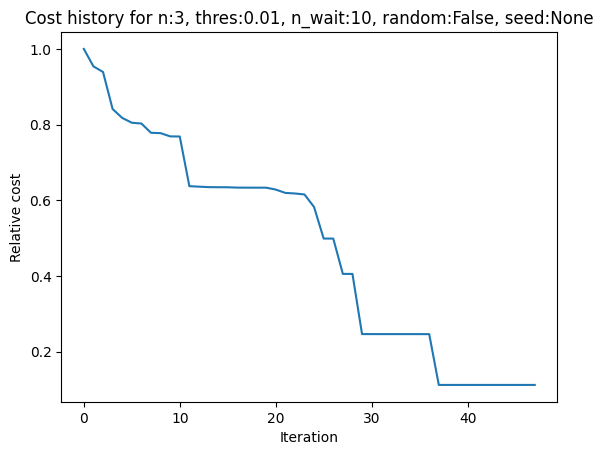

In [9]:
result.cost_plot() #cost is divided by the initial cost

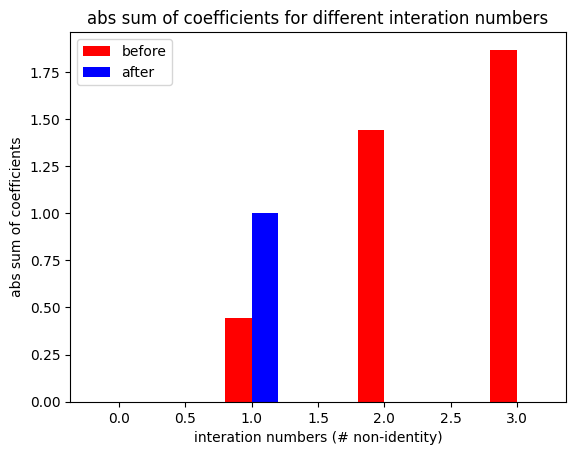

In [10]:
result.histogram()

### Simplification of a Hamiltonian generated by randomly choosing each entries  

As mentioned above, simplification of a Hamiltonian generated by randomly choosing each entries can be done better with random=True.  
We first generate random vec using "sp.random_vec" and simplify with random=True.  
When random=True, the output during simplification becomes slightly different in sense that "pauli word" changes to "axis".  
For example,  
"pauli word:(3, 3, 2)"⇒"axis:[(3, 0, 2), array([[ 0.05430472, -0.11570242,  0.01145994],
       [-1.17197404,  0.32020696,  0.97575025],
       [-0.32157457,  0.0210033 ,  1.24056976]])]"  
In above, (3, 0, 2) corresponds to $\vec{v}$ and  
 array([[ 0.05430472, -0.11570242,  0.01145994],
       [-1.17197404,  0.32020696,  0.97575025],
       [-0.32157457,  0.0210033 ,  1.24056976]])  
corresponds to $\theta_1 \vec{u}_1, \theta_2 \vec{u}_2, \theta_3 \vec{u}_3$, where the rotation axis is specified by  
$[e^{-i(\vec{u}_1\cdot\vec{\sigma}\theta_1)}\otimes e^{-i(\vec{u}_n\cdot\vec{\sigma}\theta_n)}]\sigma_{\vec{v}}[e^{i(\vec{u}_1\cdot\vec{\sigma}\theta_1)}\otimes e^{i(\vec{u}_n\cdot\vec{\sigma}\theta_n)}]$.

In [ ]:
n = 3
vec = sp.random_vec(n, seed=1234)
print(vec) #[[[0.00299249 0.00972045 0.0068395  0.01227123]
            # [0.01218712 0.00425926 0.00431975 0.01252925]
            # [0.01497093 0.01368645 0.00559089 0.00782805]
            # [0.01067911 0.01113597 0.00578517 0.00876869]]

            # [[0.00786067 0.00021513 0.01207542 0.01379127]
            # [0.00570134 0.00961557 0.00117783 0.00576288]
            # [0.01458031 0.01017778 0.00620629 0.01232391]
            # [0.00495056 0.00887654 0.01358012 0.00681521]]

            # [[0.01253356 0.00224636 0.01100408 0.01100908]
            # [0.00341863 0.01445106 0.00690845 0.01420806]
            # [0.00093452 0.00287949 0.00073993 0.01054501]
            # [0.00929101 0.00833297 0.00067694 0.00877239]]

            # [[0.00515107 0.00785886 0.00174835 0.0094874 ]
            # [0.00884289 0.00010569 0.00964753 0.01425192]
            # [0.01235194 0.01550127 0.01498128 0.01237444]
            # [0.00445705 0.00976432 0.00747022 0.00305742]]]

In [ ]:
result2 = my_simplifier(vec, random=True, seed = 234)

Now, look at results.

In [ ]:
print(result2.vec_fin)

In [ ]:
print(result2.U_lis1)
print(result2.U_lis2)

In [ ]:
result2.simp_input(out="vec")

In [ ]:
print(result2.comp_time)

In [16]:
result2.simp_change()#converges not so well (0.638 times), but it is quite difficult to make convergence well below 0.5 in general

The cost became 0.4913720371733271 times, and the convergence become 0.6382992977525844 times.


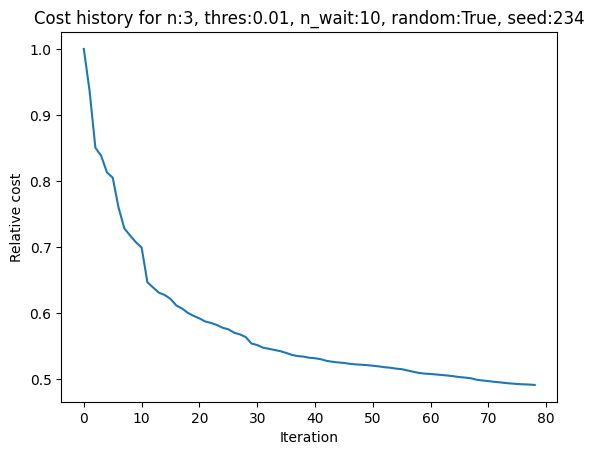

In [17]:
result2.cost_plot()

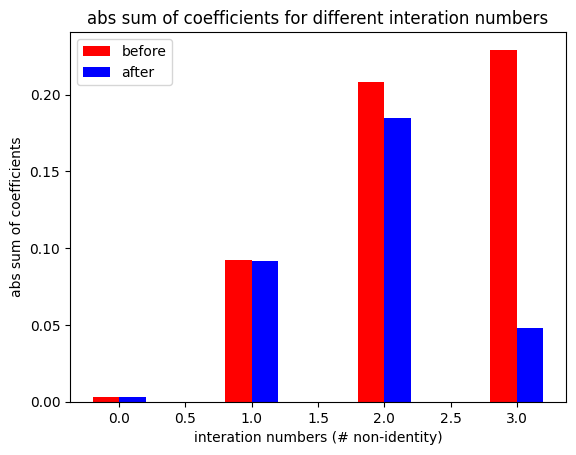

In [18]:
result2.histogram()

### Additional functions  
U_lis1 and U_lis2 gives a gate sequence to construct the unitary to simplify input vec. We can check if these sequences actually gives a simplification method.  
We can use "sp.pauli_word_to_vec" and "sp.axis_angle_to_vec" to change pauli word (something like (1, 3, 1)) and axis_angle (something like  
array([[-0.88533454, -0.2655947 ,  0.29829178],
       [ 0.5949442 , -0.77968258, -0.34353607],
       [-0.30289203,  0.17517895,  0.83369623]]))  
to vec form. Information on the sequence of pauli word and axis_angle are stored in U_lis1 and U_lis2.  
Also, vec defined by  
$[e^{-i(\vec{u}_1\cdot\vec{\sigma}\theta_1)}\otimes e^{-i(\vec{u}_n\cdot\vec{\sigma}\theta_n)}]\sigma_{\vec{v}}[e^{i(\vec{u}_1\cdot\vec{\sigma}\theta_1)}\otimes e^{i(\vec{u}_n\cdot\vec{\sigma}\theta_n)}]$  
can be obtained using "sp.small_rotation_sandwich".

In [19]:
vec_ini = result2.vec_ini.copy()
vec_fin = result2.vec_fin

for k in range(result2.itera):#result2.itera=len(result2.U_lis1)=len(result2.U_lis2)=(iteration number)
    vec_pawo = sp.pauli_word_to_vec(result2.U_lis1[k][0])
    vec_axan = sp.axis_angle_to_vec(result2.U_lis1[k][1], result2.n)
    angle = result2.U_lis2[k]
    vec_rot = sp.small_rotation_sandwich(vec_pawo, vec_axan, 1, result2.n)
    vec_ini = sp.small_rotation_sandwich(vec_ini, vec_rot, angle, result2.n)

# Check if the resulted vec_ini = vec_fin
print(np.allclose(vec_fin, vec_ini)) #True

True
